In [36]:
 ## data imported from https://www.kaggle.com/ishandutta/early-stage-diabetes-risk-prediction-dataset


## IMPORT LIBRARY

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gower
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve, auc


## DATA WRANGLING


In [38]:
df = pd.read_csv('diabetes_data_upload.csv')
df

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [40]:
df.isna().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [41]:
df.describe()

,Age
count,520.000000
mean,48.028846
std,12.151466
min,16.000000
25%,39.000000
50%,47.500000
75%,57.000000
max,90.000000



## Exploratory Data Analysis


In [42]:
bins = [0,18,30,60,100]
group = ['Teen(0-18)', 'Adult(19-30)', 'Middle Aged(31-60)', 'Senior(61-100)' ]
df['age_group'] =pd.cut(df['Age'],bins=bins, labels=group)


C:\Users\Emesi\AppData\Local\Temp\ipykernel_19544\3939289506.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['age_group', 'Gender']).size().reset_index(name='count')


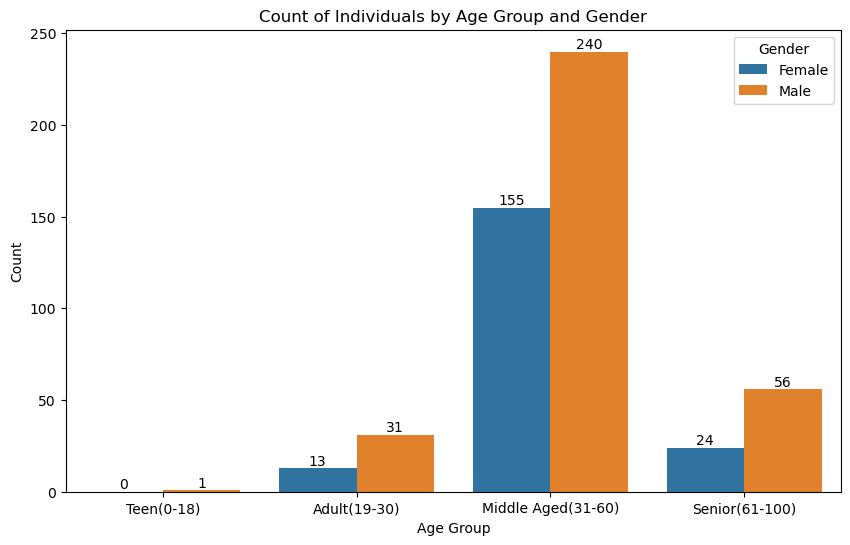

In [43]:
count_df = df.groupby(['age_group', 'Gender']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=count_df, x='age_group', y='count', hue='Gender')
for container in bar_plot.containers:
    bar_plot.bar_label(container)

# Plot context
plt.title('Count of Individuals by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()


## Using K-Nearest Neighbor for Classification 'class' column


# Using Gower Distance for KNN

In [44]:
df.drop('age_group', axis=1,inplace=True)
x = df.drop(columns='class')
y = df['class'].map({'Positive': 1, 'Negative': 0})
#Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Function to classify test samples based on Gower distance k-NN from training data
def knn_with_gower_proba(X_train, X_test, y_train, k=3):
    gower_dist_test = gower.gower_matrix(X_test, X_train)
    y_proba = []

    for i in range(len(gower_dist_test)):
        # Get k nearest neighbors
        k_neighbors = gower_dist_test[i].argsort()[:k]
        nearest_labels = y_train.iloc[k_neighbors]
        
        # Calculate the probability for class '1' (Positive)
        proba_positive = nearest_labels.sum() / k
        y_proba.append(proba_positive)

    return y_proba

# Test different values of k and record accuracy and ROC AUC
k_values = range(1, 14)
accuracies = []
auc_scores = []

for k in k_values:
    y_proba = knn_with_gower_proba(X_train, X_test, y_train, k=k)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_proba]
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # ROC-AUC Score
    auc_score = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc_score)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix KNN with Gower for k={k}:\n{cm}")
    
    # Classification Report
    cr = classification_report(y_test, y_pred)
    print(f"Classification Report KNN with Gower for k={k}:\n{cr}")
    
    print(f"ROC-AUC for KNN with Gower k={k}: {auc_score}\n")





Confusion Matrix KNN with Gower for k=1:
[[54  0]
 [ 4 98]]
Classification Report KNN with Gower for k=1:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        54
           1       1.00      0.96      0.98       102

    accuracy                           0.97       156
   macro avg       0.97      0.98      0.97       156
weighted avg       0.98      0.97      0.97       156

ROC-AUC for KNN with Gower k=1: 0.9803921568627452

Confusion Matrix KNN with Gower for k=2:
[[54  0]
 [12 90]]
Classification Report KNN with Gower for k=2:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        54
           1       1.00      0.88      0.94       102

    accuracy                           0.92       156
   macro avg       0.91      0.94      0.92       156
weighted avg       0.94      0.92      0.92       156

ROC-AUC for KNN with Gower k=2: 0.9880174291938998

Confusion Matrix KNN with Gowe

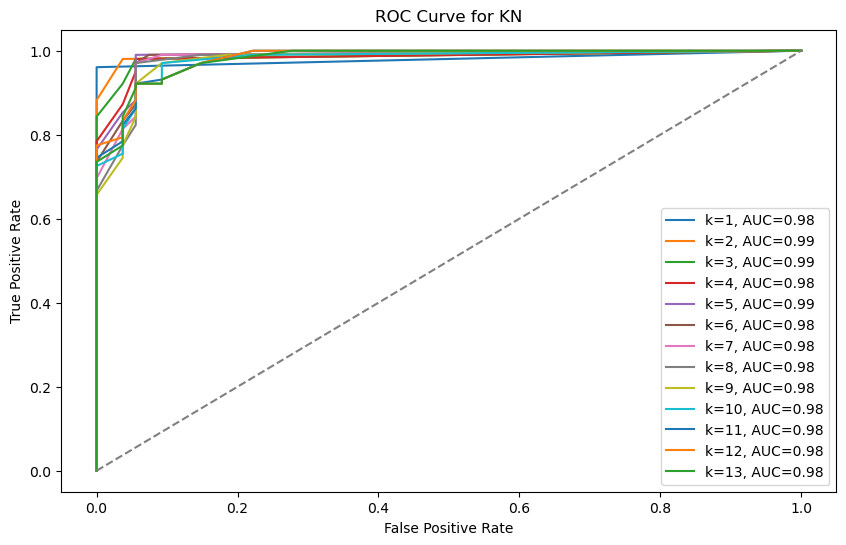

In [45]:
# Plot ROC curve for each value of k
plt.figure(figsize=(10, 6))
for k in k_values:
    y_proba = knn_with_gower_proba(X_train, X_test, y_train, k=k)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'k={k}, AUC={roc_auc:.2f}')

# Plot chance line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KN')
plt.legend(loc='lower right')
plt.show()


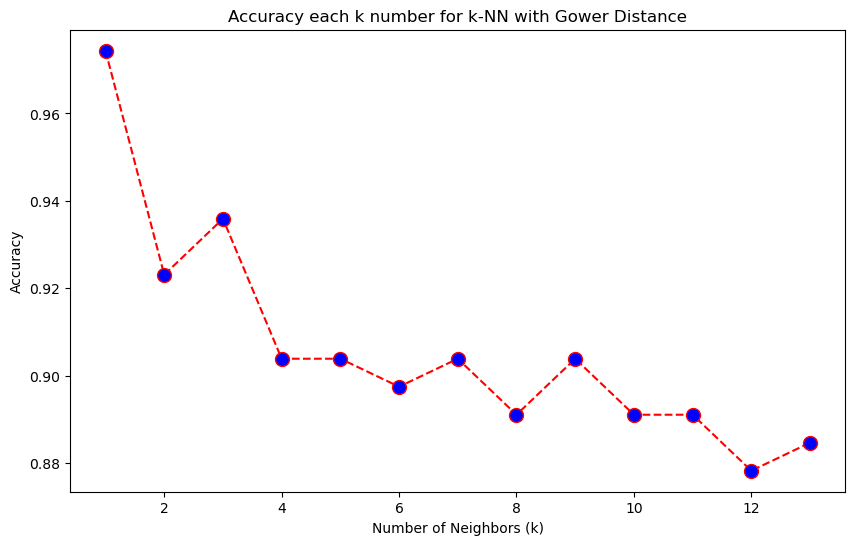

In [46]:
#Plot graph summary of accuracy each k number
plt.figure(figsize=(10, 6))
plt.plot(range(1, 14), 
         accuracies, 
         color='red', 
         linestyle='dashed', 
         marker='o',
         markerfacecolor='blue', 
         markersize=10)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy each k number for k-NN with Gower Distance')
plt.show()

# Using Euclidean Distance for KNN

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [48]:
#Convert Object Data Type to Int
converted_col =['Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 
                  'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 
                  'Irritability', 'delayed healing', 'partial paresis', 
                  'muscle stiffness', 'Alopecia', 'Obesity']
for col in converted_col:
    df[col]=df[col].map({'Yes': 1, 'No': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['class'] = df['class'].map({'Positive': 1, 'Negative': 0})
df[converted_col].head()

,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
0,0,1,0,1,0,0,0,1,0,1,0,1,1,1
1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
2,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,0,0,1,1,1,1,0,1,0,1,0,0,0,0
4,1,1,1,1,1,0,1,1,1,1,1,1,1,1


 Correlation matrix

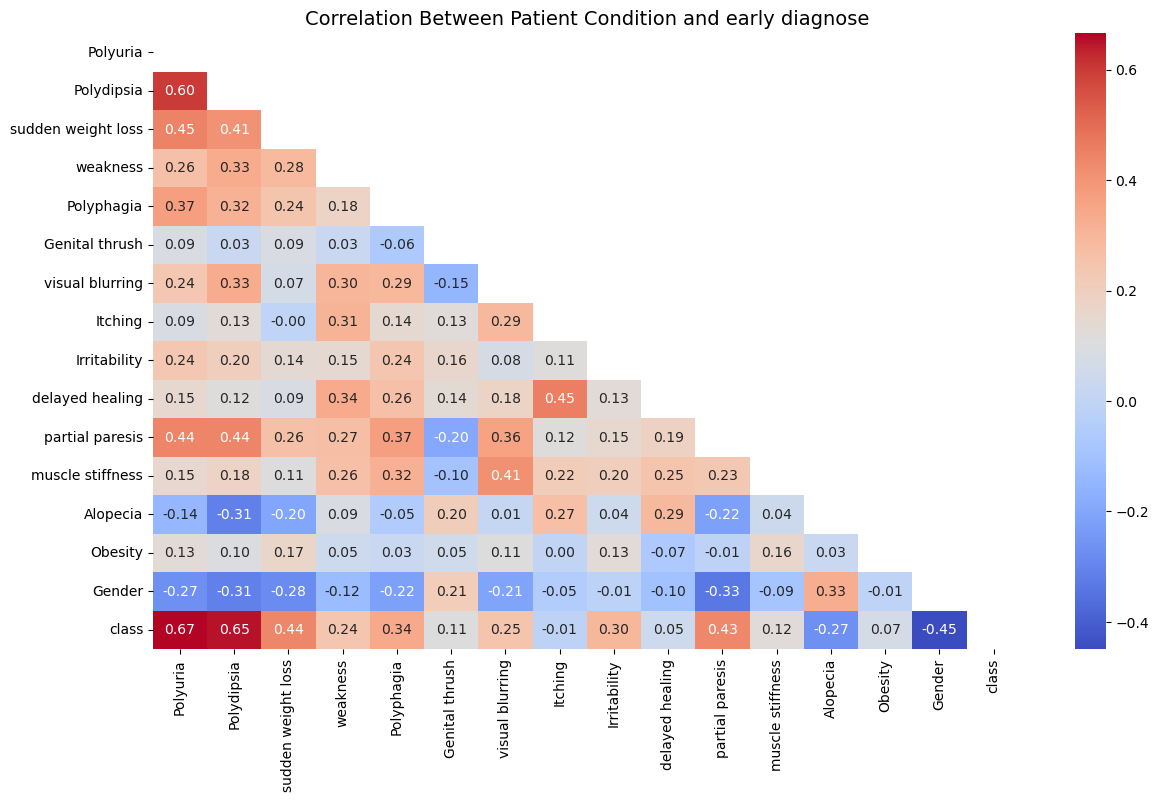

In [49]:
heatmap= converted_col+['Gender','class']
cmatrix =df[heatmap].corr()
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(cmatrix, annot=True,cmap='coolwarm',fmt=".2f", mask =np.triu(np.ones_like(cmatrix, dtype=bool)))
plt.title("Correlation Between Patient Condition and early diagnose", fontsize= 14)
plt.show()


## MODELING DATA WITH KNN




In [50]:
# Splitting data

X = df
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

#Feature scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#KNeighborsClassifier

classifier = KNeighborsClassifier(metric='euclidean')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
error = []
accuraciess=[]

for k in range(1, 14):
    knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    accuracy = accuracy_score(y_test, pred_i)
    accuraciess.append(accuracy)
# Confusion matrix
    cm = confusion_matrix(y_test, pred_i)
    print(f"Confusion Matrix KNN with Euclidean for k={k}:\n{cm}")
    
    # Classification Report
    cr = classification_report(y_test, pred_i)
    print(f"Classification Report KNN with Euclidean for k={k}:\n{cr}")
    
    # ROC-AUC Score
    auc_score = roc_auc_score(y_test, pred_i)
    print(f"ROC-AUC for KNN with Euclidean k={k}: {auc_score}\n")



Confusion Matrix KNN with Euclidean for k=1:
[[ 54   0]
 [  1 101]]
Classification Report KNN with Euclidean for k=1:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.99      1.00       102

    accuracy                           0.99       156
   macro avg       0.99      1.00      0.99       156
weighted avg       0.99      0.99      0.99       156

ROC-AUC for KNN with Euclidean k=1: 0.9950980392156863

Confusion Matrix KNN with Euclidean for k=2:
[[54  0]
 [ 3 99]]
Classification Report KNN with Euclidean for k=2:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       1.00      0.97      0.99       102

    accuracy                           0.98       156
   macro avg       0.97      0.99      0.98       156
weighted avg       0.98      0.98      0.98       156

ROC-AUC for KNN with Euclidean k=2: 0.9852941176470589

Co

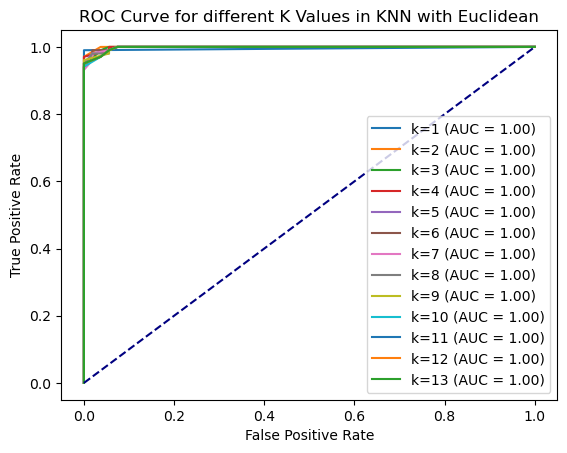

In [51]:
#Plot ROC and AUC graph
for k in range(1, 14):
    knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])  
    auc_score = auc(fpr, tpr)
    
    # Plot the ROC curve for each k
    plt.plot(fpr, tpr, label=f'k={k} (AUC = {auc_score:.2f})')
    
    # Plot ROC curve
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different K Values in KNN with Euclidean')
plt.legend(loc='lower right')
plt.show()


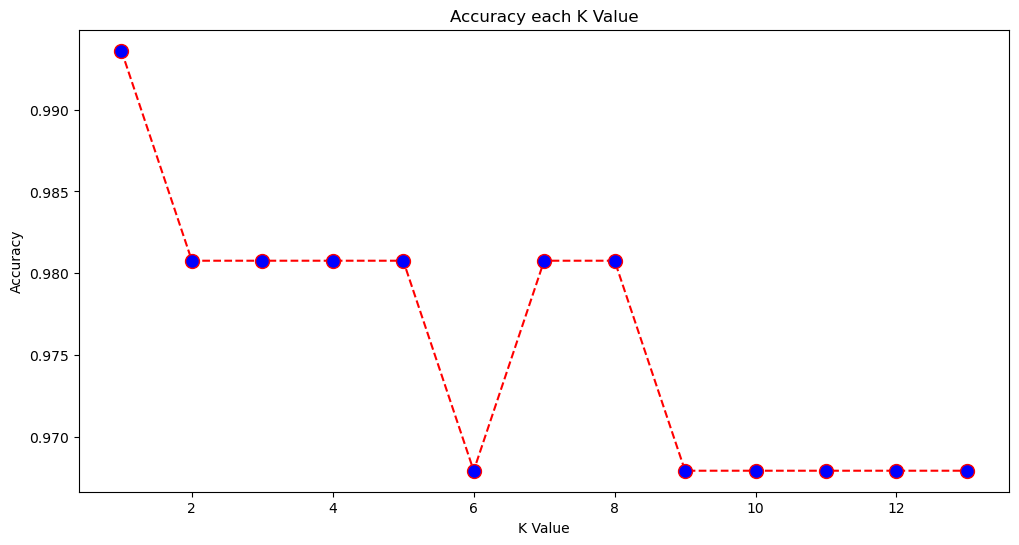

In [52]:
#Plot Accuracy for each K number
plt.figure(figsize=(12, 6))
plt.plot(range(1, 14), 
         accuraciess, 
         color='red', 
         linestyle='dashed', 
         marker='o',
         markerfacecolor='blue', 
         markersize=10)
plt.title('Accuracy each K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.show()